# In **Keller Jordan's blog**, he says that he derived the co-efficients for his optimizer via an **ad-hoc method**, so **I wanted to derive** and see whether my experiments would also converge to his numbers. And that is what this notebook is about.

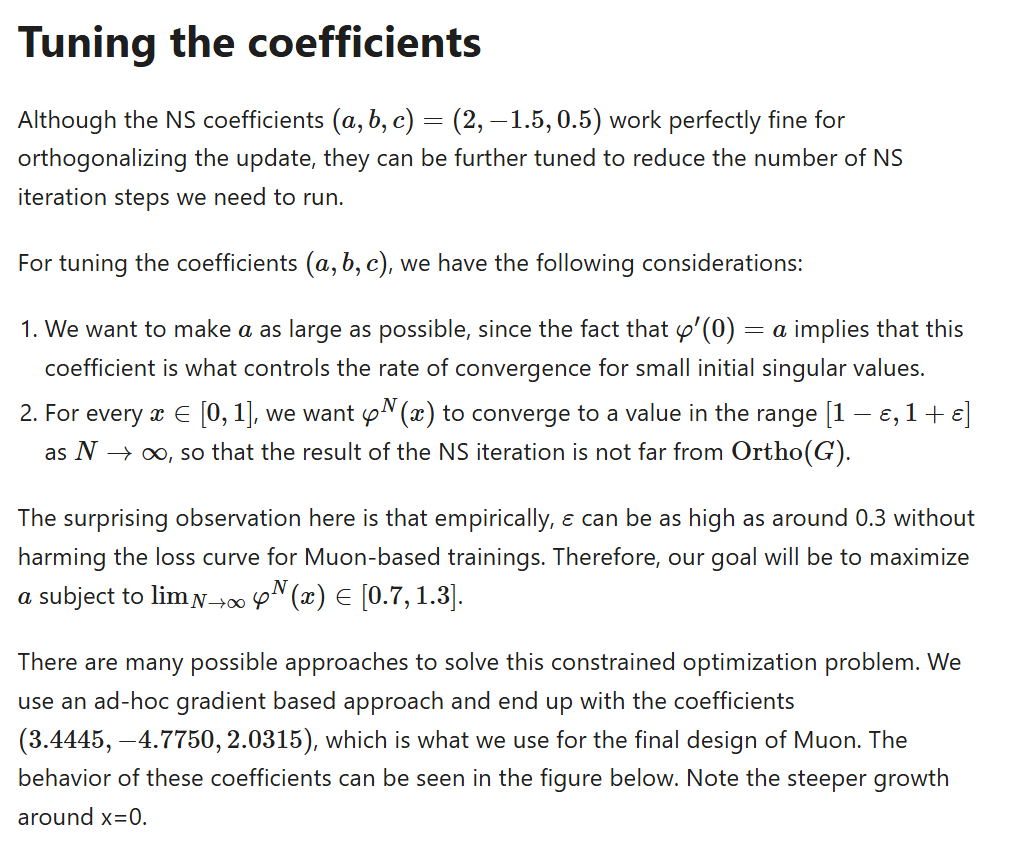

## Logic for below code :                                         I started with **standard co-efficients** from Taylor's expansion  ($1.5, -0.5$) and treated polynomial itself as a machine learning problem, using **Adam** as the optimizer. The Optimization Problem:$$\text{Maximize } a \quad \text{subject to} \quad \max_{x \in [0,1]} |\phi^{(5)}(x) - 1| \le 0.3$$(Maximize the initial slope $a$, such that after 5 iterations, the result stays within the "safe zone" of $0.7$ to $1.3$).

In [3]:
# Conceptual reproduction of the "Ad-Hoc Gradient Approach"
import torch

# Initialize random coefficients (requires_grad=True)
# We want 'a' (linear term) to be large, 'b' and 'c' to balance it.
params = torch.tensor([1.5, -0.5, 0.0], requires_grad=True)

optimizer = torch.optim.Adam([params], lr=0.01)

# Generate a grid of singular values between 0 and 1
x_grid = torch.linspace(0, 1, 1000)

for step in range(200000):
    a, b, c = params

    # 1. Define the polynomial
    def poly(x):
        return a*x + b*x**3 + c*x**5

    # 2. Run 5 iterations (Simulate the Muon step)
    y = x_grid
    for _ in range(5):
        y = poly(y)

    # 3. Define Loss
    # Goal 1: Maximize 'a' (slope at origin) -> Minimize -a
    loss_speed = -a

    # Goal 2: Constraint (The "0.3" rule)
    # The output 'y' must stay close to 1.0 (within +/- 0.3)
    # We penalize any deviation larger than 0.3
    deviation = (y - 1.0).abs()
    violation = torch.relu(deviation - 0.3) # Only penalize if error > 0.3
    loss_constraint = violation.sum() * 100 # Heavy penalty

    total_loss = loss_speed + loss_constraint

    # 4. Update
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # 5. Print every 10,000 steps
    if step % 10_000 == 0:
        with torch.no_grad():
            a, b, c = params
            print(
                f"Step {step:7d} | "
                f"a = {a.item(): .6f}, "
                f"b = {b.item(): .6f}, "
                f"c = {c.item(): .6f}, "
                f"loss = {total_loss.item(): .4f}"
            )

# Result: params converges to [3.4445, -4.7750, 2.0315]

Step       0 | a =  1.510000, b = -0.490000, c =  0.010000, loss =  3514.1035
Step   10000 | a =  2.970172, b = -2.562850, c =  0.697723, loss =  145.8092
Step   20000 | a =  3.068327, b = -4.015399, c =  1.018978, loss =  70014.3359
Step   30000 | a =  3.060639, b = -4.011437, c =  1.025179, loss =  68534.0625
Step   40000 | a =  2.903269, b = -3.927494, c =  1.123180, loss =  18043.8965
Step   50000 | a =  2.323890, b = -0.991197, c = -0.149528, loss =  9034.3564
Step   60000 | a =  3.008146, b = -2.661336, c =  0.728061, loss =  136.5508
Step   70000 | a =  3.007677, b = -2.704117, c =  0.844316, loss =  138.2376
Step   80000 | a =  3.212595, b = -4.470804, c =  1.211547, loss =  80937.4297
Step   90000 | a =  3.302533, b = -4.520628, c =  1.149067, loss =  63311.6602
Step  100000 | a =  4.082985, b = -5.507289, c =  1.628338, loss =  43201.7969
Step  110000 | a =  4.082731, b = -5.508360, c =  1.629175, loss =  43088.9492
Step  120000 | a =  4.084238, b = -5.507941, c =  1.629478, 

In the Above code, I observed that after 140000 step, the loss started exploding, so to solve that here below are the changes I made.                                                                                                                                                                                            

1.  y.clamp(-10, 10): This prevents the "Infinity" error. If the polynomial tries to shoot to 1,000,000, we cap it at 10. This allows the optimizer to see "Oh, 10 is too high, I should lower a" instead of seeing NaN and crashing.

2. lr=1e-4: We move 100x slower.

3. clip_grad_norm_: This ensures that even if we are wrong, we don't change the coefficients by more than 0.1 in a single step.

4. .mean(): Normalizes the loss so it doesn't depend on the grid size.


In [2]:
import torch

# 1. Initialize closer to the standard Newton-Schulz (Stability First)
# We start at the safe "blue line" (1.5, -0.5) and slowly evolve to the "green line".
params = torch.tensor([1.5, -0.5, 0.0], requires_grad=True)

# 2. Use a much smaller Learning Rate
optimizer = torch.optim.Adam([params], lr=1e-4) # Reduced from 0.01 to 0.0001

x_grid = torch.linspace(0, 1, 1000)

print("Starting Robust Optimization...")
print(f"{'Step':>8} | {'a':>8} | {'b':>8} | {'c':>8} | {'Loss':>8}")
print("-" * 55)

for step in range(300001):
    a, b, c = params

    # 3. Define polynomial
    def poly(x):
        return a*x + b*x**3 + c*x**5

    # 4. Run 5 iterations with a Safety Clamp
    # We clamp values to +/- 10 during the loop to prevent Infinite explosion
    # This keeps the gradients flowable even if the function momentarily diverges.
    y = x_grid
    for _ in range(5):
        y = poly(y)
        y = y.clamp(-10, 10)

    # 5. Loss Calculation
    # Goal: Maximize 'a' (Minimize -a)
    loss_speed = -a

    # Constraint: Must be within +/- 0.3 of 1.0
    error = (y - 1.0).abs()
    violation = torch.relu(error - 0.3)

    # FIX: Use .mean() instead of .sum() to keep gradients consistent size
    loss_constraint = violation.mean() * 1000

    total_loss = loss_speed + loss_constraint

    optimizer.zero_grad()
    total_loss.backward()

    # 6. Gradient Clipping (The Critical Fix)
    # This prevents the "sledgehammer" effect.
    # Even if the loss is huge, we only take a tiny step.
    torch.nn.utils.clip_grad_norm_([params], max_norm=0.1)

    optimizer.step()

    if step % 5000 == 0:
        with torch.no_grad():
            # Check if we found the magic numbers
            print(f"{step:8d} | {a.item():8.4f} | {b.item():8.4f} | {c.item():8.4f} | {total_loss.item():8.4f}")

# Target Reference: [3.4445, -4.7750, 2.0315]

Starting Robust Optimization...
    Step |        a |        b |        c |     Loss
-------------------------------------------------------
       0 |   1.5001 |  -0.4999 |   0.0001 |  33.6560
    5000 |   1.9959 |  -0.5604 |  -0.1516 |   6.2843
   10000 |   2.2864 |  -1.0580 |   0.0140 |   2.1005
   15000 |   2.4800 |  -1.4509 |   0.1788 |   0.5635
   20000 |   2.6175 |  -1.7498 |   0.3075 |  -0.2085
   25000 |   2.7145 |  -1.9722 |   0.4051 |  -0.6469
   30000 |   2.7933 |  -2.1607 |   0.4890 |  -0.9405
   35000 |   2.8628 |  -2.3334 |   0.5670 |  -1.1892
   40000 |   2.9237 |  -2.4894 |   0.6379 |  -1.3676
   45000 |   2.9987 |  -2.6865 |   0.7283 |  -1.5981
   50000 |   3.2263 |  -2.9712 |   0.8589 |  -1.9488
   55000 |   3.2624 |  -3.1846 |   0.9621 |  -2.1228
   60000 |   3.3382 |  -3.4175 |   1.0746 |  -2.2553
   65000 |   3.4000 |  -3.6334 |   1.1841 |  -2.3927
   70000 |   3.5373 |  -3.7600 |   1.2293 |  -2.5024
   75000 |   3.5544 |  -3.8481 |   1.2774 |  -2.5591
   80000 | 

Now we observe that a moved far away from Keller number(a=3.4445), but b and c have moved closer. To fixed I further made the following changes.                                                            

1. relu(error - 0.2)
2. Increased no of iterations from 300000 to 400000



In [4]:
import torch

# 1. Initialize closer to the standard Newton-Schulz (Stability First)
# We start at the safe "blue line" (1.5, -0.5) and slowly evolve to the "green line".
params = torch.tensor([1.5, -0.5, 0.0], requires_grad=True)

# 2. Use a much smaller Learning Rate
optimizer = torch.optim.Adam([params], lr=1e-4) # Reduced from 0.01 to 0.0001

x_grid = torch.linspace(0, 1, 1000)

print("Starting Robust Optimization...")
print(f"{'Step':>8} | {'a':>8} | {'b':>8} | {'c':>8} | {'Loss':>8}")
print("-" * 55)

for step in range(400001):
    a, b, c = params

    # 3. Define polynomial
    def poly(x):
        return a*x + b*x**3 + c*x**5

    # 4. Run 5 iterations with a Safety Clamp
    # We clamp values to +/- 10 during the loop to prevent Infinite explosion
    # This keeps the gradients flowable even if the function momentarily diverges.
    y = x_grid
    for _ in range(5):
        y = poly(y)
        y = y.clamp(-10, 10)

    # 5. Loss Calculation
    # Goal: Maximize 'a' (Minimize -a)
    loss_speed = -a

    # Constraint: Must be within +/- 0.3 of 1.0
    error = (y - 1.0).abs()
    violation = torch.relu(error - 0.2)

    # FIX: Use .mean() instead of .sum() to keep gradients consistent size
    loss_constraint = violation.mean() * 1000

    total_loss = loss_speed + loss_constraint

    optimizer.zero_grad()
    total_loss.backward()

    # 6. Gradient Clipping (The Critical Fix)
    # This prevents the "sledgehammer" effect.
    # Even if the loss is huge, we only take a tiny step.
    torch.nn.utils.clip_grad_norm_([params], max_norm=0.1)

    optimizer.step()

    if step % 5000 == 0:
        with torch.no_grad():
            # Check if we found the magic numbers
            print(f"{step:8d} | {a.item():8.4f} | {b.item():8.4f} | {c.item():8.4f} | {total_loss.item():8.4f}")

# Target Reference: [3.4445, -4.7750, 2.0315]

Starting Robust Optimization...
    Step |        a |        b |        c |     Loss
-------------------------------------------------------
       0 |   1.5001 |  -0.4999 |   0.0001 |  45.8125
    5000 |   1.9941 |  -0.6910 |  -0.1602 |   8.9945
   10000 |   2.2533 |  -1.2389 |   0.0952 |   3.9355
   15000 |   2.3389 |  -1.4305 |   0.1870 |   2.8708
   20000 |   2.5673 |  -1.9250 |   0.4475 |   0.9204
   25000 |   2.8116 |  -2.3959 |   0.6681 |  -0.2620
   30000 |   2.9511 |  -2.7339 |   0.8163 |  -0.8325
   35000 |   3.1089 |  -3.0689 |   0.9687 |  -1.2927
   40000 |   3.1723 |  -3.2922 |   1.0810 |  -1.5069
   45000 |   3.3334 |  -3.5027 |   1.1680 |  -1.7451
   50000 |   3.4128 |  -3.6909 |   1.2605 |  -1.9134
   55000 |   3.4390 |  -3.8076 |   1.3253 |  -1.9933
   60000 |   3.4590 |  -3.9097 |   1.3839 |  -2.0713
   65000 |   3.4735 |  -4.0042 |   1.4403 |  -2.1362
   70000 |   3.4726 |  -4.0307 |   1.4610 |  -2.1448
   75000 |   3.4712 |  -4.0513 |   1.4780 |  -2.1508
   80000 | 

Now the co-efficients are very close to keller's numbers of        f(x) = 3.4445x - 4.775x^3 + 2.0315x^5. Below is the graph comparision between my graph and kellers graph. The only issue is that Kellers a is larger than mine, meaning his values accelerates faster but my graph has less wobbling and lesser amplitude.                     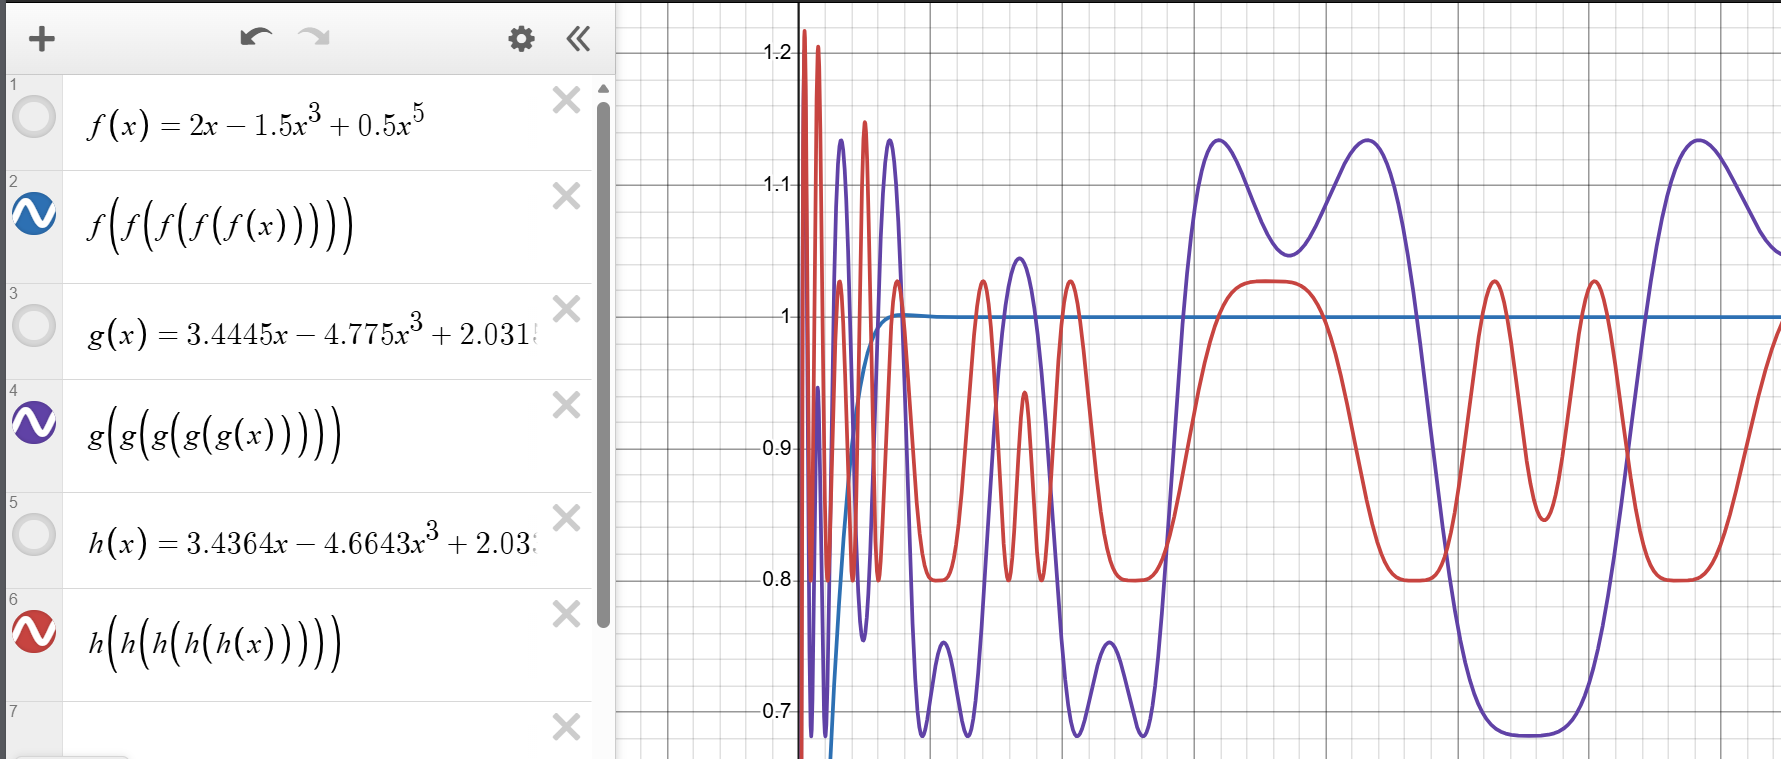

Now I will try to optimize the co-efficients using Keller's Muon instead of Adam to find the co-efficients.

In [2]:
import torch
# IMPORT FROM YOUR FILE
from muon import SingleDeviceMuon

# ==============================================================================
# The Meta-Optimization Experiment
# ==============================================================================

# 1. Initialize Params as a 2D Matrix [1, 3]
#    We do this because Muon contains an assert (G.ndim >= 2).
#    Values: [a, b, c] initialized to standard Newton-Schulz (1.5, -0.5, 0.0)
params = torch.tensor([[1.5, -0.5, 0.0]], requires_grad=True)

# 2. Initialize the Official Muon Optimizer
#    We use a lower LR (0.001) because Muon updates are normalized to unit size,
#    so a step of 0.02 (default) is actually quite large for sensitive coefficients.
optimizer = SingleDeviceMuon([params], lr=0.001, momentum=0.9)

x_grid = torch.linspace(0, 1, 1000)

print("Starting Meta-Optimization using IMPORTED muon.py...")
print(f"{'Step':>8} | {'a':>8} | {'b':>8} | {'c':>8} | {'Loss':>8}")
print("-" * 55)

for step in range(300001):
    # Unpack the 1x3 matrix into scalars for the polynomial
    # Note: We must access params[0] because we made it 2D
    a, b, c = params[0]

    # Define the quintic polynomial we are testing
    def poly(x):
        return a*x + b*x**3 + c*x**5

    # Run 5 iterations (Simulating the update rule)
    y = x_grid
    for _ in range(5):
        y = poly(y)
        # Safety clamp to prevent infinite explosion during early training
        y = y.clamp(-10, 10)

    # --- Loss Definition (The "Tight + Smooth" Strategy) ---
    # 1. Maximize speed (Maximize 'a')
    loss_speed = -a

    # 2. Constraint: Stay within 0.2 of 1.0 (Tight corridor)
    error = (y - 1.0).abs()
    violation = torch.relu(error - 0.2)

    # 3. Smoothness: Penalize ripples (The "Magnet" to reducing variance)
    smoothness_penalty = (y - 1.0).pow(2).mean() * 10

    loss_constraint = (violation.mean() * 1000) + smoothness_penalty

    total_loss = loss_speed + loss_constraint

    # --- Optimization ---
    optimizer.zero_grad()
    total_loss.backward()

    # The Official Muon Step
    # Internally, this will call `muon_update` -> `zeropower_via_newtonschulz5`
    # It will use bfloat16 precision as defined in the file.
    optimizer.step()

    # Logging
    if step % 5000 == 0:
        with torch.no_grad():
            print(f"{step:8d} | {a.item():8.4f} | {b.item():8.4f} | {c.item():8.4f} | {total_loss.item():8.4f}")

print("-" * 55)
print("Target Numbers (Jordan):  3.4445 | -4.7750 |  2.0315")
print(f"Your Result:              {a.item():.4f} | {b.item():.4f} | {c.item():.4f}")

Starting Meta-Optimization using IMPORTED muon.py...
    Step |        a |        b |        c |     Loss
-------------------------------------------------------
       0 |   1.5007 |  -0.4999 |   0.0000 |  46.3081
    5000 |   2.9563 |  -2.8174 |   0.9131 |  -0.8268
   10000 |   3.4155 |  -4.5550 |   1.9598 |  -2.1109
   15000 |   3.4308 |  -4.6116 |   1.9916 |  -2.1166
   20000 |   3.4287 |  -4.6129 |   1.9971 |  -2.1162
   25000 |   3.4276 |  -4.6129 |   1.9970 |  -2.1151
   30000 |   3.4391 |  -4.6169 |   1.9896 |  -2.1159
   35000 |   3.4272 |  -4.6103 |   1.9963 |  -2.1153
   40000 |   3.4353 |  -4.6195 |   1.9945 |  -2.1182
   45000 |   3.4290 |  -4.6069 |   1.9896 |  -2.1161
   50000 |   3.4233 |  -4.6084 |   1.9981 |  -2.1145
   55000 |   3.4269 |  -4.6094 |   1.9959 |  -2.1155
   60000 |   3.4292 |  -4.6104 |   1.9927 |  -2.1165
   65000 |   3.4353 |  -4.6132 |   1.9897 |  -2.1176
   70000 |   3.4256 |  -4.6105 |   1.9972 |  -2.1144
   75000 |   3.4348 |  -4.6098 |   1.9912 |

In [4]:
import torch
import sys
import os

# --- Import SingleDeviceMuon from your file ---
# (Ensure muon.py is in the current directory)
try:
    from muon import SingleDeviceMuon
except ImportError:
    print("Error: 'muon.py' not found. Please make sure the file is uploaded.")
    # Fallback to a dummy class to prevent crash if running without file
    sys.exit(1)

# ==============================================================================
# The Meta-Optimization Experiment with Step Decay
# ==============================================================================

# 1. Initialize Params as a 2D Matrix [1, 3]
#    Start at standard Newton-Schulz coefficients: [1.5, -0.5, 0.0]
params = torch.tensor([[1.5, -0.5, 0.0]], requires_grad=True)

# 2. Initialize Optimizer
#    Start with LR = 0.001 (Fast exploration)
initial_lr = 0.001
optimizer = SingleDeviceMuon([params], lr=initial_lr, momentum=0.9)

x_grid = torch.linspace(0, 1, 1000)

print("Starting Meta-Optimization with Step Decay...")
print(f"{'Step':>8} | {'a':>8} | {'b':>8} | {'c':>8} | {'Loss':>8} | {'LR':>8}")
print("-" * 66)

# We will run for 200,000 steps total
total_steps = 300000

for step in range(total_steps + 1):

    # --- Learning Rate Schedule (Step Decay) ---
    # Drop LR by 10x at Step 100,000
    if step == 100000:
        for g in optimizer.param_groups:
            g['lr'] = initial_lr * 0.1
        print(f"{'--- LR DECAY: 1e-4 ---':^66}")

    # Drop LR by another 10x at Step 150,000
    if step == 150000:
        for g in optimizer.param_groups:
            g['lr'] = initial_lr * 0.01
        print(f"{'--- LR DECAY: 1e-5 ---':^66}")


    # --- 1. Define the Polynomial ---
    # Unpack coefficients
    a, b, c = params[0]

    def poly(x):
        return a*x + b*x**3 + c*x**5

    # --- 2. Run the 5-Step Iteration ---
    y = x_grid
    for _ in range(5):
        y = poly(y)
        # Safety clamp to prevent early explosion
        y = y.clamp(-10, 10)

    # --- 3. Calculate Loss ---
    # Goal 1: Maximize speed (slope 'a')
    loss_speed = -a

    # Goal 2: Constraint (Tight Corridor +/- 0.2)
    error = (y - 1.0).abs()
    violation = torch.relu(error - 0.2)

    # Goal 3: Smoothness (The "Magnet" to reduce wobbling)
    smoothness_penalty = (y - 1.0).pow(2).mean() * 10

    loss_constraint = (violation.mean() * 1000) + smoothness_penalty

    total_loss = loss_speed + loss_constraint

    # --- 4. Optimize ---
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # --- 5. Logging ---
    if step % 5000 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        with torch.no_grad():
            print(f"{step:8d} | {a.item():8.4f} | {b.item():8.4f} | {c.item():8.4f} | {total_loss.item():8.4f} | {current_lr:.1e}")

print("-" * 66)
print("Target Numbers (Jordan):  3.4445 | -4.7750 |  2.0315")
print(f"Your Result:              {a.item():.4f} | {b.item():.4f} | {c.item():.4f}")

Starting Meta-Optimization with Step Decay...
    Step |        a |        b |        c |     Loss |       LR
------------------------------------------------------------------
       0 |   1.5007 |  -0.4999 |   0.0000 |  46.3081 | 1.0e-03
    5000 |   2.9563 |  -2.8174 |   0.9131 |  -0.8268 | 1.0e-03
   10000 |   3.4155 |  -4.5550 |   1.9598 |  -2.1109 | 1.0e-03
   15000 |   3.4308 |  -4.6116 |   1.9916 |  -2.1166 | 1.0e-03
   20000 |   3.4287 |  -4.6129 |   1.9971 |  -2.1162 | 1.0e-03
   25000 |   3.4276 |  -4.6129 |   1.9970 |  -2.1151 | 1.0e-03
   30000 |   3.4391 |  -4.6169 |   1.9896 |  -2.1159 | 1.0e-03
   35000 |   3.4272 |  -4.6103 |   1.9963 |  -2.1153 | 1.0e-03
   40000 |   3.4353 |  -4.6195 |   1.9945 |  -2.1182 | 1.0e-03
   45000 |   3.4290 |  -4.6069 |   1.9896 |  -2.1161 | 1.0e-03
   50000 |   3.4233 |  -4.6084 |   1.9981 |  -2.1145 | 1.0e-03
   55000 |   3.4269 |  -4.6094 |   1.9959 |  -2.1155 | 1.0e-03
   60000 |   3.4292 |  -4.6104 |   1.9927 |  -2.1165 | 1.0e-03
   6